<a href="https://colab.research.google.com/github/mid-week/bangkit_finalproject/blob/master/edible_wild_plants_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Packages & Libraries
import os
import zipfile
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

# Download dataset to /content/datasets

In [ ]:
# Getting the image dataset: Edible wild plants by gverzea on Kaggle
# Kaggle credentials
!mkdir /root/.kaggle
!echo '{"username":"nprdny","key":"c24037553f9bda47644115fb6d109f2c"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Kaggle dataset
!kaggle datasets download -d gverzea/edible-wild-plants

!ls

#unzipping the zip files and deleting the zip files
!unzip -q \*.zip  && rm *.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 761M/766M [00:04<00:00, 131MB/s]
100% 766M/766M [00:04<00:00, 164MB/s]
 datasets			    final_model_weights.hdf5
'edible wild plants metadata.xls'   sample_data
 edible-wild-plants.zip		    vanilla_model_weights.hdf5
replace datasets/dataset-test/Alfalfa/Alfalfa_test1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Ignoring outlier classes
!pwd
!rm -r datasets/dataset-test/Sunflower/
!rm -r datasets/dataset-test/'Daisy Fleabane'
!rm -r datasets/dataset-test/Dandellion

/content
 Alfalfa	       'Field Pennycress'    Pickerelweed
 Asparagus	        Fireweed	    'Pineapple Weed'
'Blue Vervain'	       'Forget Me Not'	    'Prickly Pear Cactus'
'Broadleaf Plantain'   'Garlic Mustard'     'Purple Deadnettle'
'Bull Thistle'	        Harebell	    'Queen Annes Lace'
 Cattail	        Henbit		    'Red Clover'
 Chickweed	       'Herb Robert'	    'Sheep Sorrel'
 Chicory	       'Japanese Knotweed'  'Shepherds Purse'
 Cleavers	       'Joe Pye Weed'	    'Spring Beauty'
 Coltsfoot	        Knapweed	    'Supplejack Vine'
'Common Sow Thistle'    Kudzu		    'Tea Plant'
'Common Yarrow'        'Lambs Quarters'      Teasel
 Coneflower	        Mallow		     Toothwort
'Creeping Charlie'      Mayapple	    'Vervain Mallow'
'Crimson Clover'        Meadowsweet	    'Wild Bee Balm'
'Curly Dock'	       'Milk Thistle'	    'Wild Black Cherry'
'Downy Yellow Violet'   Mullein		    'Wild Grape Vine'
 Elderberry	       'New England Aster'  'Wild Leek'
'Evening Primrose'      Partridgeberry	 

# EDA

In [ ]:
train_dir = '/content/datasets/dataset'
val_dir = '/content/datasets/dataset-test'

In [ ]:
labels = os.listdir(train_dir)

train_files = {}
for lab in labels:
  train_files[lab] = os.listdir(os.path.join(train_dir, lab))

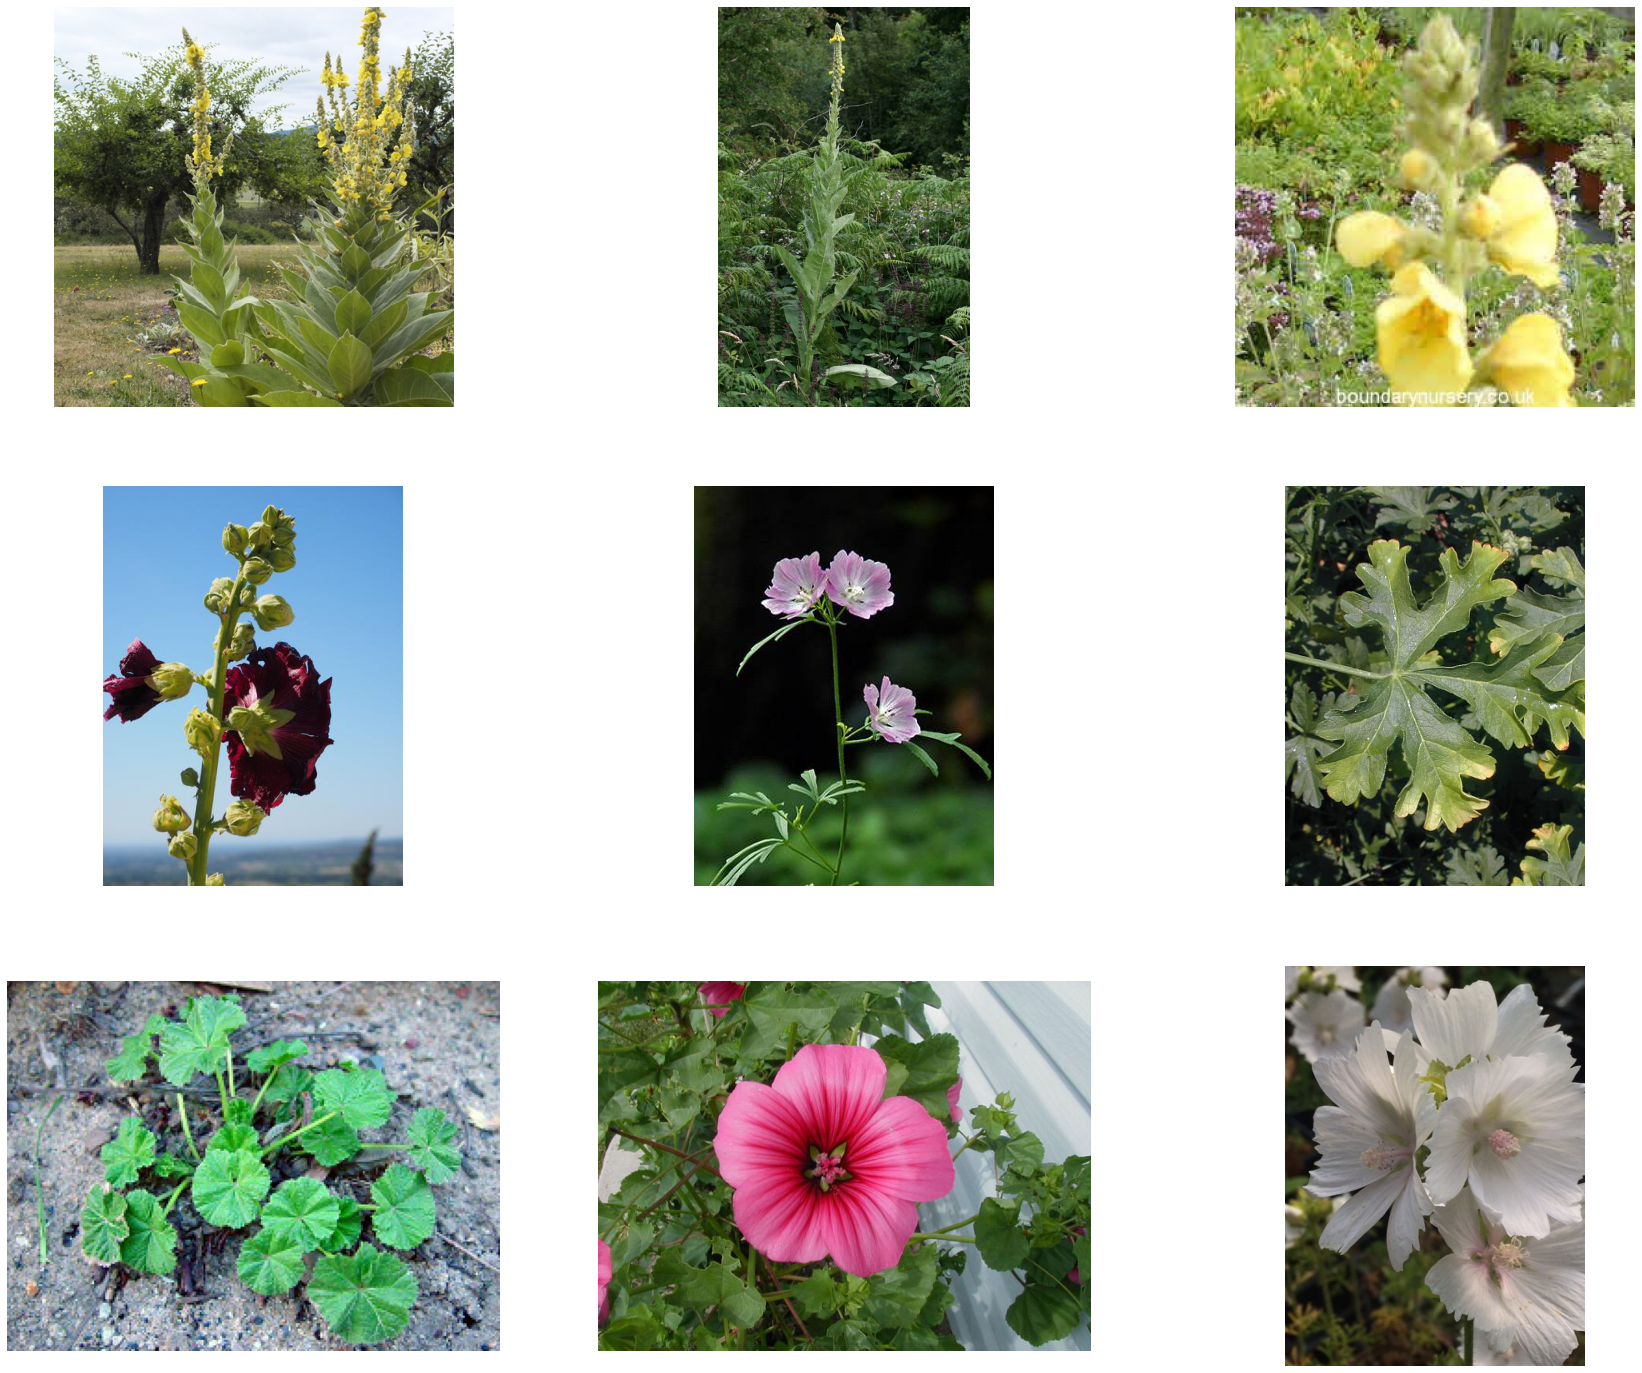

In [ ]:
# Let's try visualizing some of them
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# let's try Wild Grapevine, Japanese Knotweed, Mallow
play_labels = ['Mullein', 'Vervain Mallow', 'Mallow']

pic_id = 33
pic_filenames = {}
for l in play_labels:
  ldir = os.path.join(train_dir,l)
  pic_filenames[l] = [os.path.join(ldir,fname) for fname in os.listdir(ldir)[pic_id-3:pic_id]]

plt.figure(figsize=(30,25))
cnt = 1
for label in pic_filenames:
  for f in pic_filenames[label]:
    plt.subplot(3,3,cnt)
    img = mpimg.imread(f)
    plt.imshow(img)
    plt.axis('Off')
    # plt.show()
    cnt += 1
plt.show()

# Data Generator

In [ ]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

img_size = 160

train_dir = '/content/datasets/dataset'
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

val_dir = '/content/datasets/dataset-test'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(img_size, img_size),
	class_mode='categorical',
  batch_size=50
)

validation_generator = validation_datagen.flow_from_directory(
	val_dir,
	target_size=(img_size, img_size),
	class_mode='categorical',
  batch_size=50
)

Found 4000 images belonging to 59 classes.
Found 295 images belonging to 59 classes.


# Model (Transfer Learning)

In [ ]:
# Importing model
# Importing necessities
from tensorflow.keras import layers
from tensorflow.keras import Model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Pre-trained model
pre_trained_model = InceptionV3(input_shape = (img_size, img_size, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-06-22 13:31:38--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c10::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   176MB/s    in 0.5s    

2020-06-22 13:31:38 (176 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 8, 8, 768)


In [ ]:
!pip install -q pyyaml h5py

In [ ]:
# Modifying last layer

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final softmax layer for classification
x = layers.Dense  (59, activation='softmax')(x)

model = Model(pre_trained_model.input, x) 

# Define callbacks
'''checkpoint_path = '/tmp/checkpoint'
checkpoint_dir = os.path.dirname(checkpoint_path)

MCP = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                         verbose=1,
                                         save_best_only=True,
                                         monitor='val_accuracy',
                                         mode='max')

model.load_weights(checkpoint_path)'''

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy']
              )

In [ ]:
# Arch
#model.summary()

# Training the model
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 10,
            epochs = 50,
            validation_steps = 3,
            verbose = 1,
            #callbacks=[cp_callback]
            )

Epoch 1/50
10/10 [==============================] - 35s 4s/step - loss: 4.3330 - accuracy: 0.0500 - val_loss: 3.8230 - val_accuracy: 0.1067
Epoch 2/50
10/10 [==============================] - 35s 3s/step - loss: 3.8746 - accuracy: 0.0920 - val_loss: 3.7771 - val_accuracy: 0.0867
Epoch 3/50
10/10 [==============================] - 35s 3s/step - loss: 3.6509 - accuracy: 0.1300 - val_loss: 3.5664 - val_accuracy: 0.1267
Epoch 4/50
10/10 [==============================] - 34s 3s/step - loss: 3.4613 - accuracy: 0.1380 - val_loss: 3.2944 - val_accuracy: 0.2067
Epoch 5/50
10/10 [==============================] - 35s 3s/step - loss: 3.2941 - accuracy: 0.1920 - val_loss: 3.1263 - val_accuracy: 0.2600
Epoch 6/50
10/10 [==============================] - 35s 3s/step - loss: 3.0922 - accuracy: 0.2360 - val_loss: 3.0573 - val_accuracy: 0.2600
Epoch 7/50
10/10 [==============================] - 35s 3s/step - loss: 3.1265 - accuracy: 0.2160 - val_loss: 3.0718 - val_accuracy: 0.2333
Epoch 8/50
10/10 [==

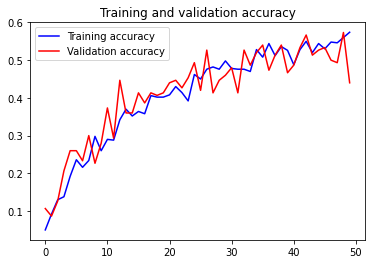

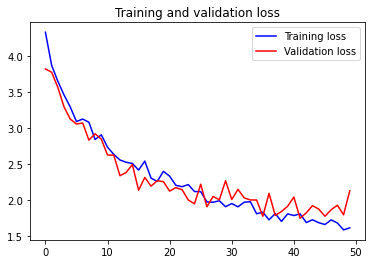

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.figure()

plt.show()

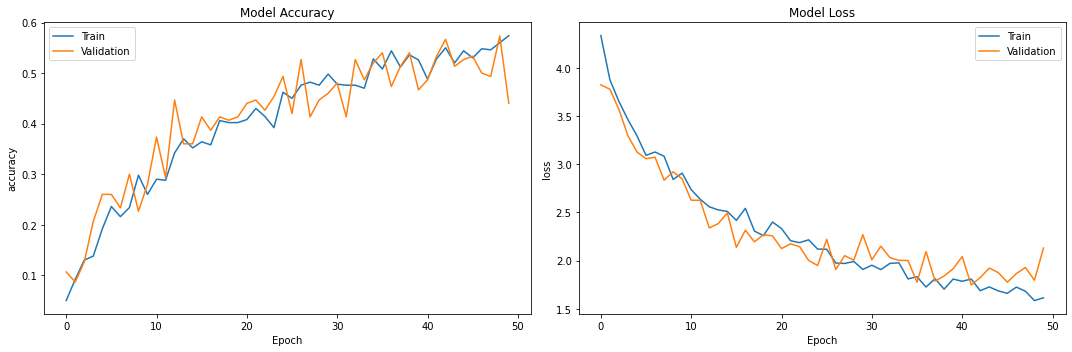

In [ ]:
def learning_curve(history,titles,legend,metrics=['accuracy','loss']):
    nplots=len(metrics)
    fig , ax = plt.subplots(1,nplots,sharex=True)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    for i in range(nplots):
        ax[i].plot(history.history[metrics[i]])
        ax[i].plot(history.history['val_{}'.format(metrics[i])])
        ax[i].set(xlabel='Epoch', ylabel=metrics[i])
        ax[i].legend(legend)
        ax[i].title.set_text(titles[i])
    plt.tight_layout()
    plt.show()

learning_curve(history,
               ['Model Accuracy','Model Loss'],
               legend=['Train','Validation'],metrics=['accuracy','loss'])

In [ ]:
print('\n# Evaluate on train data')
print('train loss, train acc:', model.evaluate(train_generator))
print('\n# Evaluate on train data')
print('test loss, test acc:', model.evaluate(validation_generator))


# Evaluate on train data
80/80 [==============================] - 207s 3s/step - loss: 1.5191 - accuracy: 0.5765
train loss, train acc: [1.519075632095337, 0.5764999985694885]

# Evaluate on train data
6/6 [==============================] - 11s 2s/step - loss: 1.8735 - accuracy: 0.5119
test loss, test acc: [1.8734910488128662, 0.511864423751831]


In [108]:
model.save('edible_plants_improved_model.h5')

In [110]:
#!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras -- edible_plants_improved_model.h5 ./tfjs_model